In [319]:
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold 
from sklearn.model_selection import RepeatedKFold

%matplotlib inline

pd.set_option('display.max_columns', None)

In [320]:
plt.rcParams.update({'font.size': 22})
pd.set_option('display.max_rows', 500)

In [321]:
abertas2018 =  pd.read_csv('csv/base_abertas2018.csv', sep=','  , engine='python')

In [322]:
df =  pd.read_csv('csv/base.csv', sep=','  , engine='python')

In [323]:
df2018 =  pd.read_csv('csv/Censo_Escolas_MG_2018.csv', sep=','  , engine='python')

In [324]:
df2010 = pd.read_csv('csv/completa2010_sit2018.csv', sep=','  , engine='python')

'\nBelo Horizonte\t3101\nMontes Claros\t3102\nTeófilo Otoni\t3103\nGovernador Valadares\t3104\nIpatinga\t3105\nJuiz de Fora\t3106\nBarbacena\t3107\nVarginha\t3108\nPouso Alegre\t3109\nUberaba\t3110\nUberlândia\t3111\nPatos de Minas\t3112\nDivinópolis\t3113\n'

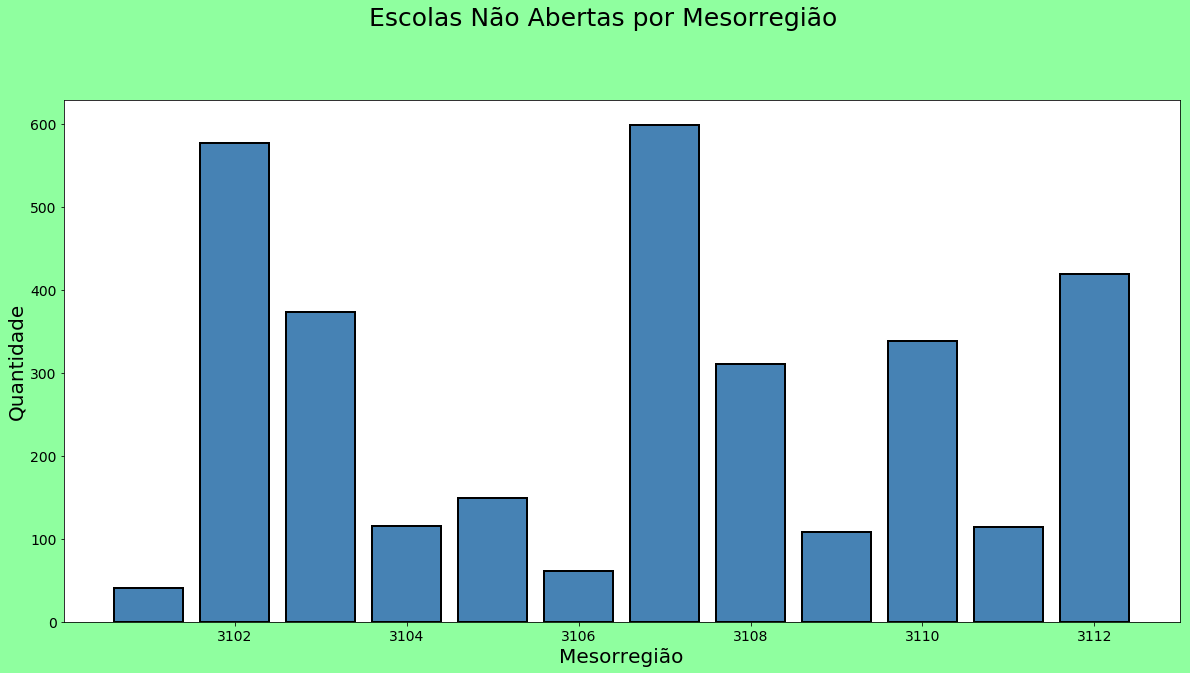

In [325]:
fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
title = fig.suptitle("Escolas Não Abertas por Mesorregião", fontsize=25)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax = fig.add_subplot(1,1, 1)
ax.set_xlabel("Mesorregião",fontsize=20)
ax.set_ylabel("Quantidade",fontsize=20) 
w_q = df['CO_MESORREGIAO'].value_counts()
w_q = (list(w_q.index), list(w_q.values))
ax.tick_params(axis='both', which='major', labelsize=14)
bar = ax.bar(w_q[0], w_q[1], color='steelblue', 
        edgecolor='black', linewidth=2)

'''
Belo Horizonte	3101
Montes Claros	3102
Teófilo Otoni	3103
Governador Valadares	3104
Ipatinga	3105
Juiz de Fora	3106
Barbacena	3107
Varginha	3108
Pouso Alegre	3109
Uberaba	3110
Uberlândia	3111
Patos de Minas	3112
Divinópolis	3113
'''

In [326]:
##### Uma medida para Infraestrutura base 2010 ###

df['infra'] = (-0.13)*df.IN_LIXO_QUEIMA-(0.18)*df.IN_ESGOTO_FOSSA+df.TP_AEE+df.IN_COMPUTADOR+df.IN_EQUIP_TV+df.IN_EQUIP_VIDEOCASSETE+df.IN_EQUIP_DVD+df.IN_EQUIP_PARABOLICA+df.IN_EQUIP_COPIADORA+df.IN_EQUIP_RETROPROJETOR+df.IN_EQUIP_IMPRESSORA+df.IN_BANHEIRO_DENTRO_PREDIO+df.IN_LOCAL_FUNC_PREDIO_ESCOLAR+df.IN_AGUA_REDE_PUBLICA+df.IN_ALIMENTACAO+df.IN_INTERNET+df.IN_BANDA_LARGA+df.IN_AGUA_FILTRADA+df.IN_ENERGIA_REDE_PUBLICA+df.IN_ESGOTO_REDE_PUBLICA+df.IN_LIXO_COLETA_PERIODICA+df.IN_LIXO_RECICLA+df.IN_SALA_DIRETORIA+df.IN_SALA_PROFESSOR+df.IN_LABORATORIO_INFORMATICA+df.IN_LABORATORIO_CIENCIAS+df.IN_SALA_ATENDIMENTO_ESPECIAL+df.IN_QUADRA_ESPORTES+df.IN_COZINHA+df.IN_BIBLIOTECA+df.IN_SALA_LEITURA+df.IN_BANHEIRO_FORA_PREDIO+df.IN_BANHEIRO_DENTRO_PREDIO+df.IN_BANHEIRO_EI+df.IN_BANHEIRO_PNE+df.IN_DEPENDENCIAS_PNE

In [327]:
# BASE 2018
abertas2018['infra'] = (-0.13)*abertas2018.IN_LIXO_QUEIMA-(0.18)*abertas2018.IN_ESGOTO_FOSSA+abertas2018.TP_AEE+abertas2018.IN_COMPUTADOR+abertas2018.IN_EQUIP_TV+abertas2018.IN_EQUIP_VIDEOCASSETE+abertas2018.IN_EQUIP_DVD+abertas2018.IN_EQUIP_PARABOLICA+abertas2018.IN_EQUIP_COPIADORA+abertas2018.IN_EQUIP_RETROPROJETOR+abertas2018.IN_EQUIP_IMPRESSORA+abertas2018.IN_BANHEIRO_DENTRO_PREDIO+abertas2018.IN_LOCAL_FUNC_PREDIO_ESCOLAR+abertas2018.IN_AGUA_REDE_PUBLICA+abertas2018.IN_ALIMENTACAO+abertas2018.IN_INTERNET+abertas2018.IN_BANDA_LARGA+abertas2018.IN_AGUA_FILTRADA+abertas2018.IN_ENERGIA_REDE_PUBLICA+abertas2018.IN_ESGOTO_REDE_PUBLICA+abertas2018.IN_LIXO_COLETA_PERIODICA+abertas2018.IN_LIXO_RECICLA+abertas2018.IN_SALA_DIRETORIA+abertas2018.IN_SALA_PROFESSOR+abertas2018.IN_LABORATORIO_INFORMATICA+abertas2018.IN_LABORATORIO_CIENCIAS+abertas2018.IN_SALA_ATENDIMENTO_ESPECIAL+abertas2018.IN_QUADRA_ESPORTES+abertas2018.IN_COZINHA+abertas2018.IN_BIBLIOTECA+abertas2018.IN_SALA_LEITURA+abertas2018.IN_BANHEIRO_FORA_PREDIO+abertas2018.IN_BANHEIRO_DENTRO_PREDIO+abertas2018.IN_BANHEIRO_EI+abertas2018.IN_BANHEIRO_PNE+abertas2018.IN_DEPENDENCIAS_PNE

Text(0, 0.5, 'Quantidade de Escolas')

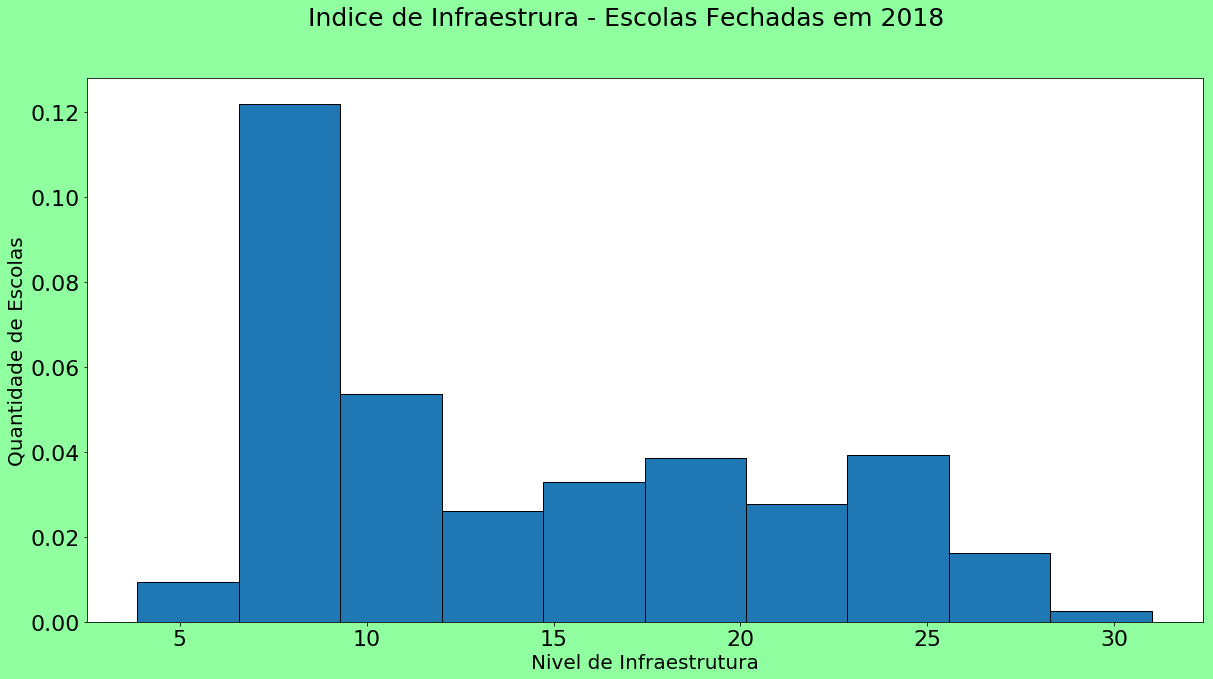

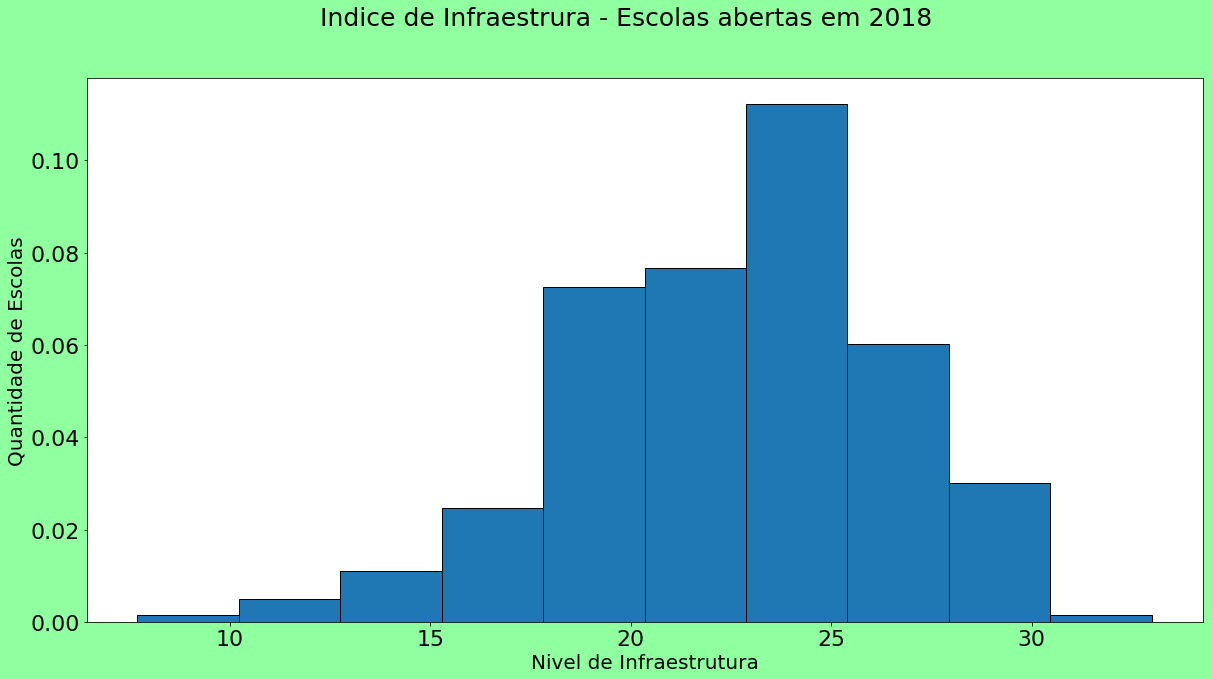

In [328]:
fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
title = fig.suptitle("Indice de Infraestrura - Escolas Fechadas em 2018", fontsize=25)
plt.hist(df['infra'], density=True, edgecolor='k')
plt.xlabel('Nivel de Infraestrutura', fontsize=20)
plt.ylabel('Quantidade de Escolas', fontsize=20)

fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
title = fig.suptitle("Indice de Infraestrura - Escolas abertas em 2018", fontsize=25)
plt.hist(abertas2018['infra'], density=True, edgecolor='k')
plt.xlabel('Nivel de Infraestrutura', fontsize=20)
plt.ylabel('Quantidade de Escolas', fontsize=20)

/home/martimallow/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/martimallow/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Quantidade de Escolas')

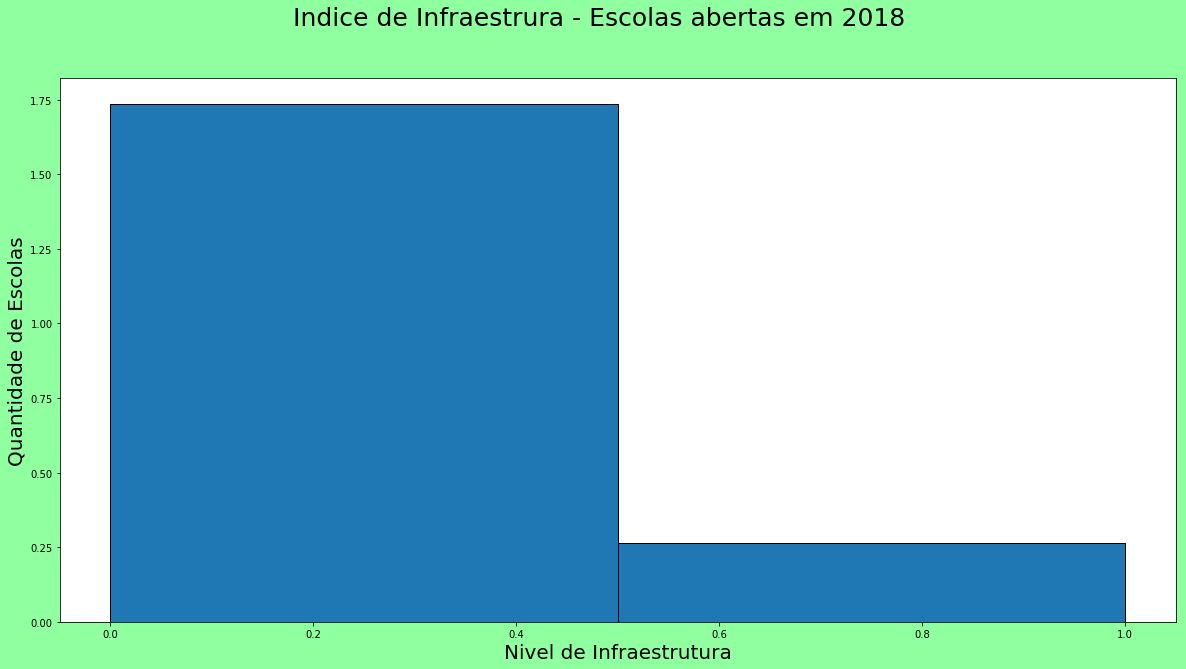

In [316]:
#testando possiveis correlaçoes
fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
title = fig.suptitle("Indice de Infraestrura - Escolas abertas em 2018", fontsize=25)
plt.hist(df2018['IN_AUDITORIO'], bins=2, density=True, edgecolor='k')
plt.xlabel('Nivel de Infraestrutura', fontsize=20)
plt.ylabel('Quantidade de Escolas', fontsize=20)

In [270]:
# BASE 2010
df2010 = df2010.apply (pd.to_numeric, errors='coerce')
df2010 = df2010.fillna(0)
df2010.isnull().values.any()

False

In [271]:
#juntando todo mundo que nao está aberto como 0
df2010['TP_SITUACAO_FUNCIONAMENTO_y'] = np.where(df2010['TP_SITUACAO_FUNCIONAMENTO_y'] > 1, 0, df2010['TP_SITUACAO_FUNCIONAMENTO_y'])

In [272]:
df2010 = df2010.astype('float64', raise_on_error = False)
df2010 = df2010.fillna(0)

/home/martimallow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: the raise_on_error=False keyword is deprecated, use errors='ignore' instead
  """Entry point for launching an IPython kernel.


In [298]:
'''
df2010['infra'] =  (
    0.76*df2010.TP_REGULAMENTACAO+
    0.74*df2010.IN_LOCAL_FUNC_PREDIO_ESCOLAR+
    0.79*df2010.IN_AGUA_FILTRADA+
    0.70*df2010.IN_AGUA_REDE_PUBLICA+
    0.79*df2010.IN_ENERGIA_REDE_PUBLICA+
    0.64*df2010.IN_ESGOTO_REDE_PUBLICA+
    0.70*df2010.IN_LIXO_COLETA_PERIODICA+
    0.68*df2010.IN_SALA_DIRETORIA+
    0.60*df2010.IN_SALA_PROFESSOR+
    0.75*df2010.IN_COZINHA+
    0.57*df2010.IN_BIBLIOTECA+
    0.78*df2010.IN_BANHEIRO_DENTRO_PREDIO+
    0.75*df2010.IN_EQUIP_TV+
    0.57*df2010.IN_EQUIP_VIDEOCASSETE+
    0.72*df2010.IN_EQUIP_DVD+
    0.50*df2010.IN_EQUIP_COPIADORA+
    0.50*df2010.IN_EQUIP_RETROPROJETOR+
    0.66*df2010.IN_EQUIP_IMPRESSORA+
    0.68*df2010.IN_COMPUTADOR+
    0.58*df2010.IN_INTERNET+
    0.50*df2010.IN_BANDA_LARGA+
    0.68*df2010.IN_ALIMENTACAO+
    0.78*df2010.ID_MATERIAL_ESP_NAO_UTILIZA
    
    )

'''
df2010['infra'] =  (
    1* df2010.TP_REGULAMENTACAO +
    1* df2010.IN_LOCAL_FUNC_PREDIO_ESCOLAR +
    0.8* df2010.TP_OCUPACAO_PREDIO_ESCOLAR +
    1* df2010.IN_AGUA_FILTRADA +
    0.83* df2010.IN_AGUA_REDE_PUBLICA +
    1* df2010.IN_ENERGIA_REDE_PUBLICA +
    0.78* df2010.IN_ESGOTO_REDE_PUBLICA +
    0.9* df2010.IN_LIXO_COLETA_PERIODICA +
    0.8* df2010.IN_SALA_DIRETORIA +
    0.72* df2010.IN_SALA_PROFESSOR +
    0.54* df2010.IN_LABORATORIO_INFORMATICA +
    0.52* df2010.IN_QUADRA_ESPORTES +
    1* df2010.IN_COZINHA +
    0.65* df2010.IN_BIBLIOTECA +
    0.71* df2010.IN_BIBLIOTECA_SALA_LEITURA +
    1* df2010.IN_BANHEIRO_DENTRO_PREDIO +
    0.51* df2010.IN_BANHEIRO_PNE +
    0.75* df2010.IN_SECRETARIA +
    0.64* df2010.IN_BANHEIRO_CHUVEIRO +
    0.7* df2010.IN_REFEITORIO +
    0.7* df2010.IN_DESPENSA +
    0.51* df2010.IN_PATIO_COBERTO +
    -0.65* df2010.IN_PATIO_DESCOBERTO +
    0.52* df2010.IN_AREA_VERDE +
    0.90* df2010.IN_EQUIP_TV +
    0.84* df2010.IN_EQUIP_DVD +
    0.62* df2010.IN_EQUIP_COPIADORA +
    0.76* df2010.IN_EQUIP_IMPRESSORA +
    0.55* df2010.IN_EQUIP_IMPRESSORA_MULT +
    0.84* df2010.IN_EQUIP_SOM +
    0.7* df2010.IN_EQUIP_MULTIMIDIA +
    0.65* df2010.IN_EQUIP_FOTO +
    0.90* df2010.IN_COMPUTADOR +
    0.83* df2010.IN_INTERNET +
    0.73* df2010.IN_BANDA_LARGA +
    0.85* df2010.IN_ALIMENTACAO +
    0.55* df2010.IN_COMUM_PRE 
    
    )



In [299]:
df2010.TP_SITUACAO_FUNCIONAMENTO_y.corr(df2010.infra)
#df2010.corrwith(df2010['TP_SITUACAO_FUNCIONAMENTO_y'], axis = 0) 
#0.8710451541366004

0.871139235937427

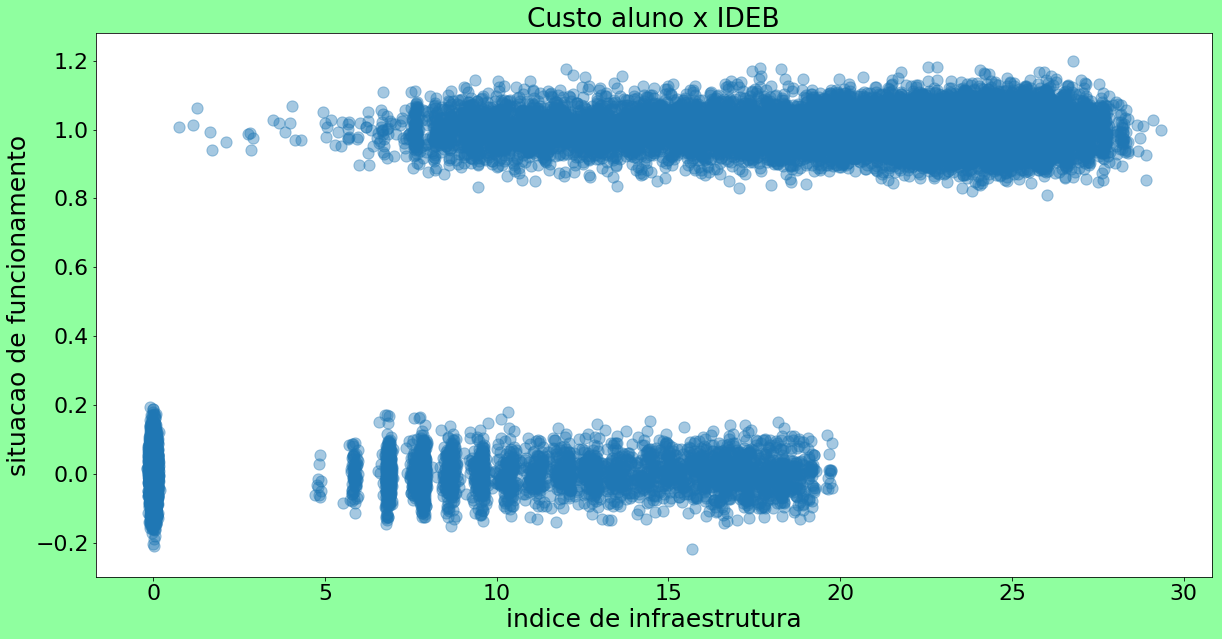

In [300]:
n = df2010.shape[0]

x = df2010['infra']  + np.random.normal(0, 0.05, size=n)
y =   df2010['TP_SITUACAO_FUNCIONAMENTO_y'] + np.random.normal(0, 0.05, size=n)

fig = plt.figure(figsize = (20, 10))
fig.patch.set_facecolor('xkcd:mint green')
plt.scatter(x, y, s=np.pi*40, alpha=0.4)
plt.title('Custo aluno x IDEB')
plt.ylabel('situacao de funcionamento',fontsize=25)
plt.xlabel('indice de infraestrutura',fontsize=25)
plt.show()

In [315]:
#transformando saida em inteirios pois logitico só funciona pra binario
df2010['TP_SITUACAO_FUNCIONAMENTO_y'] =  df2010['TP_SITUACAO_FUNCIONAMENTO_y'].astype('int64')

In [314]:
#escolhendo parametros

X = df2010['infra'].values.reshape(-1, 1)
Y = df2010['TP_SITUACAO_FUNCIONAMENTO_y']
# loss = log, logistic
# penalty = none, sem regularizar
# fit_intercept = false, colocamos na marra em X já um intercepto
# penalty == none pois não vamos regularizar
# solver indica como o sklearn vai otimizar
model = LogisticRegression(penalty='none', fit_intercept=False, solver='lbfgs')
model.fit(X,Y ) ### Execute gradiente descendente!!!

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [312]:
X_train = X[:19904]
X_test = X[19904:]
Y_train = Y[:19904]
Y_test = Y[19904:]

model = LogisticRegression(penalty='none', fit_intercept=False, solver='lbfgs')
model = model.fit(X_train, Y_train)

In [313]:
score = model.score(X_test, Y_test)
print(score)

0.8828976673309108


In [310]:
#tentando usar cross validation

'''
kf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=None) 

for train_index, test_index in kf.split(X):
      #print("Train:", train_index, "Validation:",test_index)
      X_train, X_test = X[train_index], X[test_index] 
      y_train, y_test = y[train_index], y[test_index]
'''